# Web and Text Analytics - Sentiment Analysis

### Authors
- Francois Cubelier
- Lisa Bueres
- Romain Charles

## Introduction
This report showcases our results for sentiment analysis. We experimented different types of recurrent neural networks on this task: basic RNN, LSTM and GRU. We studied the effect of attention on these models as well as testing different word embeddings (GloVe, FastText and Word2Vec). Finally, document level embedding were also investigated (WME, Bert sentence, GloVe average and a task specific average).

### Sentiment Analysis
Sentiment analysis is the analysis of texts such as reviews in order to detect the polarity implied by the author. The polarity is either positive, negative or neutral.

## Methods

### RNNs

3 types of recurrent neural networks were tested: Base RNN, LSTM and GRUs. We also experimented with different hyperparameters: 
- The number of hidden layers: 1 or 2
- The size of the hidden state: 100 or 300
- The type of output layer after the main network: linear or MLP (for more details on the MLP, see models/RNN.py)

### Attention
We tested 2 types of attention based on scaled dot-product attention: 
- Last hidden layer attention: 
$Attention(Q, K, V) = softmax(QK^\top/\sqrt n)V$ where V = K = output sequence and Q is the last hiddent state
- Self-attention followed by last hiddent layer attention.
First we apply a self attention:
$Attention_1(Q, K, V) = V' = softmax(QK^\top/\sqrt n)V$ where V = K = Q = output sequence.
Then we apply the last hidden layer attention:
$Attention_2(Q', K', V') = softmax(Q'K'^\top/\sqrt n)V'$ where V' = K' = output sequence of self-attention and Q is the last hidden state of the RNN.


### Document level embeddings
There numerous document level embeddings in the literature.
In tested 4 methods:
- Average glove embeddings: a sentence is encoded by the average of its GloVe word embeddings.
- Task specific average: a sentece is encoded by the average of its word embeddings and the word embedding are trained from scratch for this task.
- WME: Document embedding based on the distance (based on Word Mover Distance) between the document and randomly generated documents.
- Sentence BERT: a pre-trained document level embedding based on BERT (all-MiniLM-L6-v2 model).

In order to predict the class from the document embedding, 2 types of model were tested: linear model and MLP.

## Experiments

### Experimental setup

For our experiments, we train our model with Adam optimizer ($\beta_1 = 0.9, \beta_2=0.999)$) with a lreaning rate of $0.001$. For experiment 1 to 4, a batch size of 32 was used and 128 for experiment 5. 
We used early stopping, the validation loss is monitored during training (on 10% of the initial training set) and the training is stopped if there were no improvement during the last t epochs (t=4 for Exp.1 and 6 for the others). Later, the number of iterations is also called the number of steps. The last model is kept and is typically overfitted.

For the initial experiment, a vocabulary size of 10000 was used and 20000 for the remaining experiments. The GloVe pretrained embeddings are the glove.840B.300d ones. Word2Vec are pretrained 300 dimensional embeddings from Google news.

While the first experiment uses different hyperparameters for the RNNs, the others use a word embedding of size 300, a hidden dimension of 100, one hidden layer, a linear output layer, and sentences are truncated at 580 words.

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Experiment 1: Hyperparameters
In this experiment, we compare RNN, LSTM and GRU over the IMDB datasets and examine the results by varying hyperparameters.

In [114]:
df_1 = pd.read_csv("results/exp1_all.csv")

#### Model
As can be seen by computing the mean of the test accuracy and the test loss, GRU and LSTM are better than RNN. GRU and LSTM have mean accuracies very close GRU being slighty better than LSTM, but LSTM is able to better reduce the loss in average. RNN performed around 30% less than the others for the accuracy and the the loss, which is a non negligible difference.

Both GRU and LSTM use memory while the simple RNN does not. This allows the two first to have more information than the RNN when performing the classification, explaining the difference in performance.

In [115]:
df_1.groupby("Model Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Model Type,,
GRU,0.883545,0.446573
LSTM,0.880375,0.375391
RNN,0.548980,0.678701


<AxesSubplot:xlabel='Model Type', ylabel='Test Loss'>

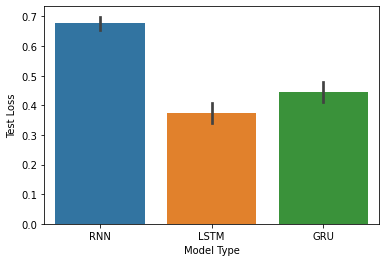

In [116]:
sns.barplot(x="Model Type", y="Test Loss", data=df_1)

#### Output Layer Type
The table below shows that linear layers are better than MLP layers, on both the accuracy and the loss. This is probably due to the Multi-Layer Perceptron (MLP) leading to a more complex model, because of non linearity, with overfitting on the training set and thus reduced performance on the testing set, while the linear model is simpler and limited in overtfitting thanks to its structure not allowing too complex functions. Additionally, using a more complex model after the RNN may not force the RNN to learn a good representation of the sentence (not linearly separable).

In [117]:
df_1.groupby("Output Layer Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Output Layer Type,,
MLP,0.759180,0.523465
linear,0.782753,0.476979


#### Number of layers
As shown in the table below, adding one layer slighlty improves the average accuracy and decreases the loss. However it also comes with an increase in computation time.

In [118]:
df_1.groupby("Number of Layers").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Number of Layers,,
1,0.766113,0.506772
2,0.775820,0.493671


#### Number of features in the hidden state
Increasing the number of features in the hidden state (hidden size) leads to slightly less performance. This is shown in the table below where the size goes from 100 to 300. The average difference is really tight as it is of around 2% for both the average accuracy and the average loss.

In [119]:
df_1.groupby("Hidden Size").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Hidden Size,,
100,0.784587,0.483162
300,0.757347,0.517282


#### Full results
This table allowing to compare the results for all the hyper-parameters simultaneously corroborates what has been said previously. However, the effect of the number of layers is not clear: increasing from 1 to 2 sometimes increases the performance, sometimes decreases it.
But this table brings new information: the best test accuracy, 0.88768, is reached by the GRU model, with linear layer, a hidden size of 100 and two layers. This configuration has also the fourth smallest loss, which upholds the qualification as the best in the table. It converged in only 5632 steps. The minimal loss, 0.287417, is obtained by a LSTM model, also linear with 100 features and 1 layer. The test accuracy is also the third better, thus making this combination of parameters a pretty good choice too. The number of steps reaches 6336 this time, meaning more computation time. Without distinguishing the model, the hyper parameters of those two combinations are the same.

At the opposite, the worst performances are obtained with the basic RNN, far from LSTM and GRU. The worst accuracy, 0.49788, is the RNN-linear with a size of 300 and 2 layers. The highest loss, 0.722325, is achieved with the RNN-linear, with a size of 300 and 1 layer.

We can see that the number of steps required for the LSTM is generally higher than the ones of GRU and RNN with values at 6336 or above up to 8448, while the RNN has the smallest at 4224 and GRU at 4928.

In [120]:
df_1.groupby(["Model Type","Output Layer Type", "Hidden Size", "Number of Layers"], sort=True).max()[["Test Acc", "Test Loss", "step"]]

Test Acc  \
Model Type Output Layer Type Hidden Size Number of Layers             
GRU        MLP               100         1                  0.88512   
                                         2                  0.87712   
                             300         1                  0.88096   
                                         2                  0.88552   
           linear            100         1                  0.88768   
                                         2                  0.88440   
                             300         1                  0.88564   
                                         2                  0.88192   
LSTM       MLP               100         1                  0.87304   
                                         2                  0.87956   
                             300         1                  0.87700   
                                         2                  0.88324   
           linear            100         1                  0.88560   
                                         2                  0.87576   
                             300         1                  0.88392   
                                         2                  0.88488   
RNN        MLP               100         1                  0.50516   
                                         2                  0.56544   
                             300         1                  0.50000   
                                         2                  0.49800   
           linear            100         1                  0.60004   
                                         2                  0.69612   
                             300         1                  0.52920   
                                         2                  0.49788   

                                                           Test Loss  step  
Model Type Output Layer Type Hidden Size Number of Layers                   
GRU        MLP               100         1                  0.423704  7744  
                                         2                  0.475683  6336  
                             300         1                  0.523954  5632  
                                         2                  0.436582  6336  
           linear            100         1                  0.348002  5632  
                                         2                  0.444155  7040  
                             300         1                  0.482910  5632  
                                         2                  0.437592  4928  
LSTM       MLP               100         1                  0.462807  8448  
                                         2                  0.410049  8448  
                             300         1                  0.410662  6336  
                                         2                  0.392338  7040  
           linear            100         1                  0.287417  6336  
                                         2                  0.326734  7040  
                             300         1                  0.383310  7040  
                                         2                  0.329815  6336  
RNN        MLP               100         1                  0.689820  4224  
                                         2                  0.667698  5632  
                             300         1                  0.694153  5632  
                                         2                  0.694128  3520  
           linear            100         1                  0.652205  8448  
                                         2                  0.609671  4928  
                             300         1                  0.722325  7040  
                                         2                  0.699611  5632

#### Validation Loss monitoring
One can see that the RNN does not learn much. Both the LSTM and the GRU do overfit the training set but the GRU reach its minimal loss in less iterations than LSTM.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

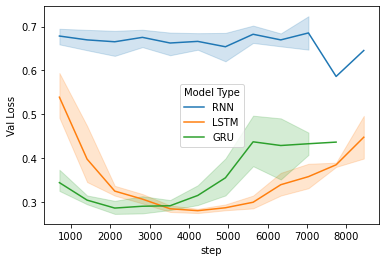

In [121]:
sns.lineplot(x="step", y="Val Loss", hue="Model Type", data=df_1)

#### Comparison of accuracy and loss
We can see on the plot below that high accuracy and small loss are achieved by both LSTM and GRU, present in the bottom right corner. GRU is seen here to always keep a high accuracy while LSTM is more spread. Sadly, the green points cover some orange ones, making it a bit harder to analyse.
Once again at the opposite, the RNN model keeps a high loss and a small accuracy. It is indeed present the most in the upper left corner. 
We can notice that GRU and RNN never overlap, while LSTM overlaps with the RNN but barely, and mostly overlaps with the GRU model.

TODO: y a des hyperparamètres à mentionner ici ?

<AxesSubplot:xlabel='Val Acc', ylabel='Val Loss'>

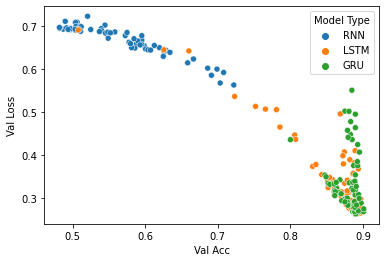

In [122]:
sns.scatterplot(x="Val Acc", y="Val Loss", hue="Model Type", data=df_1)

#### Distribution of the loss and the accuracy
Both loss and accuracy distributions for the three models looks like the normal distribution.
For the accuracy, we can see that the RNN is highly spread, with a mean of around 0.5, which is close to the value seen before. The mean used at the beginning ot the report thus hide some better results, but those are not significant. The accuracies of the LSTM and GRU model are at the opposite very tight around the mean, which was of 0.88.
For the loss, the one of the RNN model is moderately spread, but the mean is high. The losses of LSTM and GRU are a bit more spread, still moderately, but have their mean around better values: 0.45 for GRU and 0.38 for LSTM. As mentionned in the previous section about the scatterplot, LSTM and GRU overlap a lot, while RNN barely overlaps with the two.
The performances of LSTM and GRU are very close and this is visible here too. GRU reaches more often a better accuracy but LSTM can reach the same, while LSTM is also able to get a great part of its points in the smallest loss area. But the spread means that a small loss is not always guaranteed, leading to the configuration of hyper-parameters being even more important.


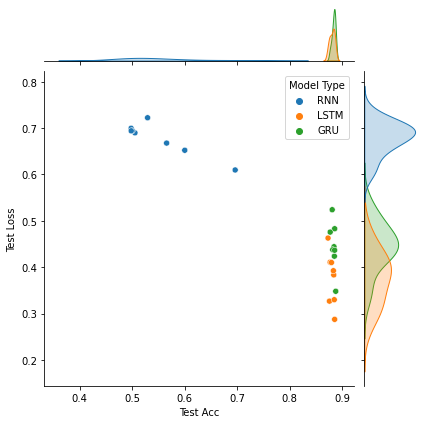

In [123]:
sns.jointplot(x="Test Acc", y="Test Loss", hue="Model Type", data=df_1, kind="scatter")

### Conclusion of Experiment 1:
Overall, the best results are definitely obtained by GRU and LSTM. As the hyper parameters are the same for the smallest loss and the best accuracy, choosing between GRU and LSTM is more of a matter of computation time and preferences than anything else. 

## Experiment 2: Attention
In this experiment, we analyse the effect of adding an attention layer for the sentiment analysis.

In [124]:
df_2 = pd.read_csv("results/exp2_all.csv")

#### Model
Here, we can more or less make the same conclusion as in experiment 1: GRU and LSTM are better than RNN. However, GRU is able to better reduce the loss in average and RNN performed around 10% less than the others for the accuracy and the loss. RNN shows way better results than before, marking a higher influence of the attention. It's around 20% better. LSTM has seen its loss slightly increase, making GRU now the best for both accuracy and loss.

In [125]:
df_2.groupby("Model Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Model Type,,
GRU,0.886920,0.422186
LSTM,0.883933,0.448550
RNN,0.749907,0.505979


####

#### Attention type
We can see that, on average, the self attention reaches better results for both accuracy and loss, even if the attention on the last hidden layer gives performances not too far from the first.

TODO: dire pourquoi selon le fonctionnement ?

In [126]:
df_2.groupby("Attention").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Attention,,
last_hidden_layer,0.867253,0.442866
none,0.777413,0.540949
self,0.876093,0.392901


<AxesSubplot:xlabel='Attention', ylabel='Test Loss'>

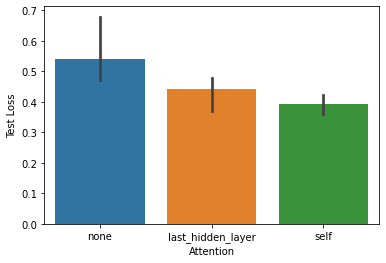

In [127]:
sns.barplot(x="Attention", y="Test Loss", data=df_2)

#### Validation Loss monitoring
Let us analyse the plot below. We can see that, increasing the number of steps, the loss curve for without attention layer decreases up to 0.4 at around 3600 steps before increasing up to 8000 steps. The area around is very large. For the last hidden attention layer, increasing the steps first decreases the loss but then increases it again when exceeding around 3600 steps. Large loss values are even achieved for a large number of steps, up to almost 0.5 at 12000 steps. The self-attention layer seems to be the best. It's more stable, the loss curve does not increase very much and the area around is tighter.

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

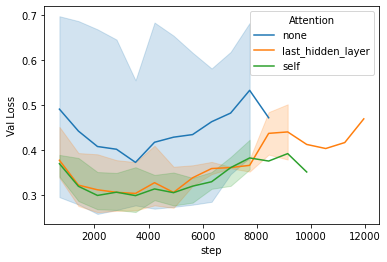

In [128]:
sns.lineplot(x="step", y="Val Loss", hue="Attention", data=df_2)

#### Full results

This table allowing to compare the results for all the hyper-parameters simultaneously corroborates what has been said previously.
This table brings new information: the best test accuracy, 0.89, is reached by the GRU model, with the last hidden attention layer. This is the best configuration as the loss is one of the 2 smallest losses in the table. Its number of steps is 6336, which is a quite decent amount. The minimal loss, 0.359689, is realized by a RNN model, with a self attention layer. The test accuracy is among the two lowest, 0.85824, but it is still high. It's a pretty good choice too. The number of steps reaches 9856 this time, meaning more computation time.

At the opposite, the worst performances is realized with the RNN model with none attention layer. It presents the worts features. The accuracy is 0.56364 and the loss is 0.678793. 

We can say that, with a self attention layer, results are globally pretty good for both accuracy and loss.

In [129]:
df_2.groupby(["Model Type","Attention"], sort=True).max()[["Test Acc", "Test Loss", "step"]]

Test Acc  Test Loss   step
Model Type Attention                                    
GRU        last_hidden_layer   0.89000   0.369427   6336
           none                0.88584   0.473536   6336
           self                0.88492   0.423595   7744
LSTM       last_hidden_layer   0.88392   0.479714   9152
           none                0.88276   0.470518   8448
           self                0.88512   0.395419   7744
RNN        last_hidden_layer   0.82784   0.479456  11968
           none                0.56364   0.678793   7744
           self                0.85824   0.359689   9856

### Conclusion of Experiment 2:
Overall, the best results are definitely obtained with a self attention layer. GRU and LSTM have globally better results than RNN. So, the choice is more of a matter of computation time and preferences than anything else. 

## Experiment 3: Word level embedding
In this third experiment, we compare results based on three word level embeddings: Glove, FastText and Word2Vec.

In [130]:
df_3 = pd.read_csv("results/exp3_all.csv")

#### Embedding
We can see in the table below that there are not much differences between the performances of the three enmbeddings. Glove is the one performing faster in accuray, while FastText is the best for the loss. However, they all are quite close in accuracy for the ones reached in the previous experiments, with only 2% between the worst here and the best previously. The loss, at the opposite, is further from the best obtained before but still stays in a range of values frequently seen.

In [131]:
df_3.groupby("Embedding").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Embedding,,
FastText,0.86768,0.404606
Glove,0.88456,0.456487
Word2Vec,0.87614,0.420189


<AxesSubplot:xlabel='Embedding', ylabel='Test Loss'>

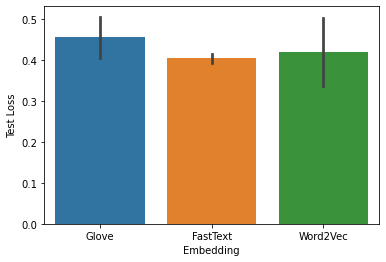

In [132]:
sns.barplot(x="Embedding", y="Test Loss", data=df_3)

#### Full results
As saif before, GRU and LSTM have pretty close results, and this is again the case despite the different embeddings. Glove combined with LSTM gives the best accuracy with a value of 0.88744, but with also the higher loss in the table. The smallest loss is achieved with LSTM and Word2Vec, while the accuracy of this configuration is quite good. There seems to be a trade-off between accuracy and loss as no embedding is the best for both.

In [133]:
df_3.groupby(["Model Type","Embedding"], sort=True).max()[["Test Acc", "Test Loss"]]

Test Acc  Test Loss
Model Type Embedding                     
GRU        FastText    0.87404   0.414855
           Glove       0.88744   0.506794
           Word2Vec    0.87744   0.503496
LSTM       FastText    0.86132   0.394357
           Glove       0.88168   0.406180
           Word2Vec    0.87484   0.336882

#### Validation loss monitoring
The first to reach its minimal loss is Glove, with around 3500 steps. The second is FastText at 4000 steps, where the area is really tighted, which is interesting because it assures the minimal loss to be reached by all configurations. The third is Word2Vec, at around 5500 steps, and another minimum after 10000 steps, which is not interesting as it leads to much more computation time. Word2Vec also presents the flaw of having its loss tight on only a small range of steps, the beginning being very large and thus not representative. Glove is really a good choice here as it combines the fastest computation and reaches the best loss.

TODO: euh vérifie quand même le temps de computation ?

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

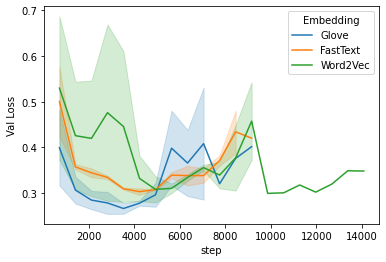

In [134]:
sns.lineplot(x="step", y="Val Loss", hue="Embedding", data=df_3)

#### Comparison of loss and accuracy
Most of the points on the scatterplot below are in the bottom right corner, where the performance is the best, but Glove has a few points out of reach for the two others that are also the best. Overall, the three still have really good performances and it obvious here.

<AxesSubplot:xlabel='Val Acc', ylabel='Val Loss'>

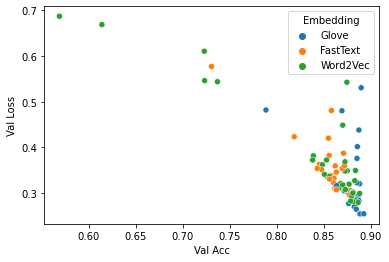

In [135]:
sns.scatterplot(x="Val Acc", y="Val Loss", hue="Embedding", data=df_3)

#### Distribution of the loss and the accuracy
We can see that Glove and Word2Vec are highly spread on the loss axis, while less for the accuracy. FastText does exactly the contrary. The more it is spread, the less we can hope to obtain the desired performance. But with the great tuning, Glove can outperform FastText Word2Vec.

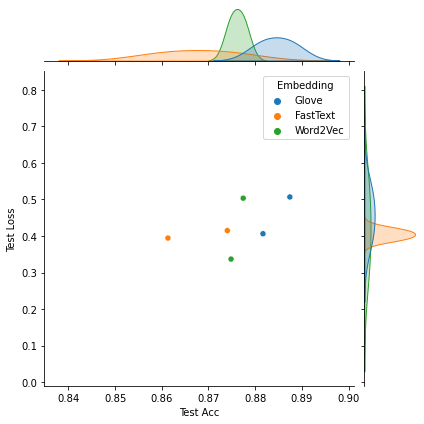

In [136]:
sns.jointplot(x="Test Acc", y="Test Loss", hue="Embedding", data=df_3, kind="scatter")

### Conclusion of Experiment 3
There is not much to conclude, the performance of the three embeddings being very close. However, Glove seems to stand out more often than the two others along the experiment.

## Experiment 4: Document level embedding

In [137]:
df_4 = pd.read_csv("results/exp4_all.csv")

In [138]:
df_4.groupby("Model Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Model Type,,
from-scratch-average,0.862396,0.424313
pretrained-average,0.770364,0.500188
sentence-bert,0.822952,0.436322
wme,0.763836,0.496433


<AxesSubplot:xlabel='Model Type', ylabel='Test Loss'>

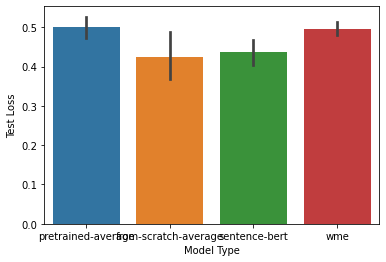

In [139]:
sns.barplot(x="Model Type", y="Test Loss", data=df_4)

#### Ouput layer type
Here we can see that if some information can be extracted, it can be extracted mostly linearly.

In [140]:
df_4.groupby("Output Layer Type").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Output Layer Type,,
MLP,0.803902,0.486118
linear,0.805872,0.442510


<AxesSubplot:xlabel='step', ylabel='Val Loss'>

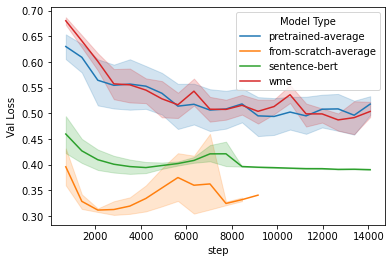

In [141]:
sns.lineplot(x="step", y="Val Loss", hue="Model Type", data=df_4)

<AxesSubplot:xlabel='Val Acc', ylabel='Val Loss'>

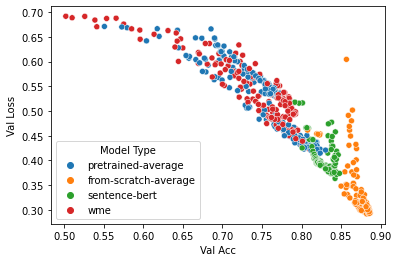

In [142]:
sns.scatterplot(x="Val Acc", y="Val Loss", hue="Model Type", data=df_4)

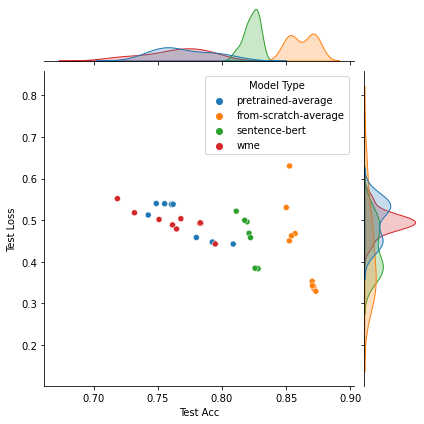

In [143]:
sns.jointplot(x="Test Acc", y="Test Loss", hue="Model Type", data=df_4, kind="scatter")

In [144]:
df_4.groupby(["Model Type","Output Layer Type","Embedding Size"], sort=True).mean()[["Test Acc", "Test Loss"]]

Test Acc  Test Loss
Model Type           Output Layer Type Embedding Size                     
from-scratch-average MLP               300             0.853320   0.508252
                     linear            300             0.871472   0.340375
pretrained-average   MLP               300             0.783368   0.461443
                     linear            300             0.757360   0.538933
sentence-bert        MLP               384             0.818312   0.488791
                     linear            384             0.827592   0.383853
wme                  MLP               300             0.760608   0.485986
                     linear            300             0.767064   0.506880

## Experiment 5: Performance on different datasets

In [145]:
df_5 = pd.read_csv("results/exp5_all.csv")

In [146]:
df_5.groupby("Dataset").mean()[["Test Acc", "Test Loss"]]

,Test Acc,Test Loss
Dataset,,
IMDB,0.88884,0.320222
Yelp,0.64795,0.801553


<AxesSubplot:xlabel='Dataset', ylabel='Test Loss'>

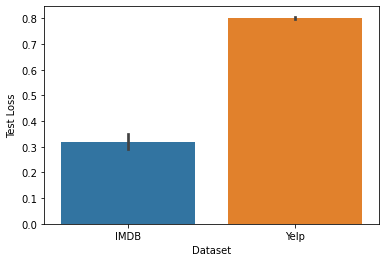

In [147]:
sns.barplot(x="Dataset", y="Test Loss", data=df_5)

<AxesSubplot:xlabel='step', ylabel='Val Loss'>

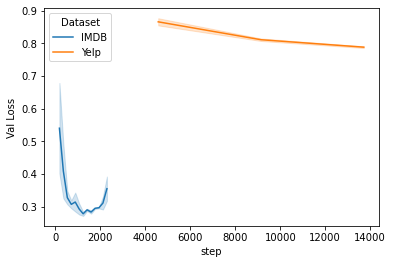

In [148]:
sns.lineplot(x="step", y="Val Loss", hue="Dataset", data=df_5)

In [149]:
df_5.groupby(["Dataset", "Model Type"], sort=True).max()[["Test Acc", "Test Loss", "step"]]

Test Acc  Test Loss   step
Dataset Model Type                            
IMDB    GRU          0.89212   0.350571   2288
        LSTM         0.88556   0.289872   2288
Yelp    GRU          0.64574   0.806808  16000
        LSTM         0.65016   0.796297  16000

## Bibliography

- Nils Reimers and Iryna Gurevych (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. CoRR, abs/1908.10084.
- Lingfei Wu and Ian En-Hsu Yen and Kun Xu and Fangli Xu and Avinash Balakrishnan and Pin-Yu Chen and Pradeep Ravikumar and Michael J. Witbrock (2018). Word Mover's Embedding: From Word2Vec to Document Embedding. CoRR, abs/1811.01713.
- Maas, A., Daly, R., Pham, P., Huang, D., Ng, A., & Potts, C. (2011). Learning Word Vectors for Sentiment Analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies (pp. 142–150). Association for Computational Linguistics.
- Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735-1780.
- Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, & Yoshua Bengio. (2014). Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation
- Jeffrey Pennington, Richard Socher, and Christopher D. Manning. (2014). GloVe: Global Vectors for Word Representation. 
- Grave, E., Bojanowski, P., Gupta, P., Joulin, A., & Mikolov, T. (2018). Learning Word Vectors for 157 Languages. In Proceedings of the International Conference on Language Resources and Evaluation (LREC 2018).
- Tomas Mikolov, Kai Chen, Greg Corrado, & Jeffrey Dean. (2013). Efficient Estimation of Word Representations in Vector Space. 
- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, & Illia Polosukhin. (2017). Attention Is All You Need. 

